## Objective

In this code, a cloud free composite using the Scene CLassification (SCL) bands from the Sentinel 2 images is created for a small area in Bangalore (computed through a buffer around a center point in latitude and longitude). The Sentinel 2 data are obtained from the SpatioTemporal Asset Catalogs ([STAC](https://stacspec.org/en)). For an overview of public and private catalogues, please see [here](https://stacspec.org/en/about/datasets/). One can also browse the catalogues, using this [link](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1?.language=en) of Radiant Earth.

In this code, the Earth Search catalogue of Element 84 is used ([link 1](https://www.element84.com/earth-search/) and [link 2](https://stacindex.org/catalogs/earth-search#/)). The Cloud Optimised Geotiffs (COGs) will be accessed. COGs are nothing but "special" GeoTiffs but with an internal structure in blocks which alllows the user to only access that part that is needed for the analysis. For more explanation, please see [here](https://carpentries-incubator.github.io/geospatial-python/05-access-data.html).

For an overview of the SCL bands, please see the following link (among others) [here](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview).

In this code, Dask is not yet used as the data is rather small but this will be done in another script. Dask is a python library for parallel and distributed computing and is integrated with xarray.

## Installing the packages and importing the packages

In [2]:
!pip install pystac_client stackstac geopandas pandas rich  --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.6/181.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 23.9 MB/s eta 0:00:00


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rich.table
import stackstac
from pystac_client import Client
from shapely.geometry import Point

We call the pystac client based on the centre coordinates for Bangalore (in order to have a small area). We will select a coordinate and create a small bounding box around it (following this link [here](https://stackstac.readthedocs.io/en/latest/basic.html)).

## Accessing the STAC catalogue

In [4]:
# The latitude and the long

lon, lat = 77.594566, 12.971599 # https://www.latlong.net/place/bengaluru-karnataka-india-18658.html

First, let us create a list of all the collections that are available in the Earth Search catalogue.

In [ ]:
catalog = Client.open('https://earth-search.aws.element84.com/v1')
collections = catalog.get_all_collections()

datasets = []
for col in collections:
    datasets.append({'collection': col.id, 'description': col.description})
df_col = pd.DataFrame(datasets)
df_col

collection                                        description
0     cop-dem-glo-30  The Copernicus DEM is a Digital Surface Model ...
1               naip  The [National Agriculture Imagery Program](htt...
2     sentinel-2-l2a  Global Sentinel-2 data from the Multispectral ...
3     sentinel-2-l1c  Global Sentinel-2 data from the Multispectral ...
4     cop-dem-glo-90  The Copernicus DEM is a Digital Surface Model ...
5      landsat-c2-l2  Atmospherically corrected global Landsat Colle...
6     sentinel-1-grd  Sentinel-1 is a pair of Synthetic Aperture Rad...
7  sentinel-2-c1-l2a  Sentinel-2 Collection 1 L2A, data from the Mul...

We are interested in the 'sentinel-2-l2a' collection.

Let us take the images based on the latitude and longitude for January and February during the year 2022:

In [ ]:
%%time
items = catalog.search(
    intersects=Point(lon, lat),
    collections=["sentinel-2-l2a"],
    datetime="2022-01-01/2022-02-28"
).item_collection()
len(items)

CPU times: user 36.1 ms, sys: 1.65 ms, total: 37.8 ms
Wall time: 490 ms


12

We see that we have obtained 12 images. Before stacking the different images into one datacube/stack (more below), let us try to visualise some of the images. Before doing so, let us create a dataframe to get a rough idea how the images look (in terms of relevant tile, cloud cover, etc).

In [ ]:
items_df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')
items_df

geometry  \
0   POLYGON ((76.91832 13.56107, 77.86186 13.55204...   
1   POLYGON ((76.92784 13.56100, 77.86186 13.55204...   
2   POLYGON ((76.92294 13.56104, 77.86186 13.55204...   
3   POLYGON ((76.92904 13.56099, 77.86186 13.55204...   
4   POLYGON ((76.92479 13.56102, 77.86186 13.55204...   
5   POLYGON ((76.93135 13.56097, 77.86186 13.55204...   
6   POLYGON ((76.92571 13.56102, 77.86186 13.55204...   
7   POLYGON ((76.92608 13.56101, 77.86186 13.55204...   
8   POLYGON ((76.92645 13.56101, 77.86186 13.55204...   
9   POLYGON ((76.92183 13.56105, 77.86186 13.55204...   
10  POLYGON ((76.92109 13.56105, 77.86186 13.55204...   
11  POLYGON ((76.91925 13.56107, 77.86186 13.55204...   

                     created     platform constellation instruments  \
0   2022-11-06T06:37:00.484Z  sentinel-2a    sentinel-2       [msi]   
1   2022-11-06T09:52:27.910Z  sentinel-2b    sentinel-2       [msi]   
2   2022-11-06T06:54:17.134Z  sentinel-2a    sentinel-2       [msi]   
3   2022-11-06T06:50:06.975Z  sentinel-2b    sentinel-2       [msi]   
4   2022-11-06T06:50:42.704Z  sentinel-2a    sentinel-2       [msi]   
5   2022-11-05T22:24:46.153Z  sentinel-2b    sentinel-2       [msi]   
6   2022-11-05T22:23:36.021Z  sentinel-2a    sentinel-2       [msi]   
7   2022-11-06T09:29:15.561Z  sentinel-2b    sentinel-2       [msi]   
8   2022-11-06T07:14:33.310Z  sentinel-2a    sentinel-2       [msi]   
9   2022-11-06T06:35:51.988Z  sentinel-2b    sentinel-2       [msi]   
10  2022-11-03T13:00:04.569Z  sentinel-2a    sentinel-2       [msi]   
11  2022-11-05T22:54:54.359Z  sentinel-2b    sentinel-2       [msi]   

    eo:cloud_cover  proj:epsg  mgrs:utm_zone mgrs:latitude_band  \
0         1.459464      32643             43                  P   
1        15.424986      32643             43                  P   
2        26.337385      32643             43                  P   
3         4.555767      32643             43                  P   
4        53.212631      32643             43                  P   
5        13.944308      32643             43                  P   
6        49.479482      32643             43                  P   
7         0.128002      32643             43                  P   
8        14.857989      32643             43                  P   
9        16.847939      32643             43                  P   
10       42.358284      32643             43                  P   
11        1.285770      32643             43                  P   

   mgrs:grid_square  ...                                      s2:granule_id  \
0                GQ  ...  S2A_OPER_MSI_L2A_TL_VGS2_20220227T074813_A0349...   
1                GQ  ...  S2B_OPER_MSI_L2A_TL_VGS2_20220222T074708_A0259...   
2                GQ  ...  S2A_OPER_MSI_L2A_TL_VGS4_20220217T074540_A0347...   
3                GQ  ...  S2B_OPER_MSI_L2A_TL_VGS2_20220212T073935_A0257...   
4                GQ  ...  S2A_OPER_MSI_L2A_TL_VGS4_20220207T074021_A0346...   
5                GQ  ...  S2B_OPER_MSI_L2A_TL_VGS2_20220202T074618_A0256...   
6                GQ  ...  S2A_OPER_MSI_L2A_TL_VGS4_20220128T075238_A0344...   
7                GQ  ...  S2B_OPER_MSI_L2A_TL_VGS1_20220123T075226_A0254...   
8                GQ  ...  S2A_OPER_MSI_L2A_TL_VGS4_20220118T065859_A0343...   
9                GQ  ...  S2B_OPER_MSI_L2A_TL_VGS1_20220113T075354_A0253...   
10               GQ  ...  S2A_OPER_MSI_L2A_TL_VGS1_20220108T074532_A0341...   
11               GQ  ...  S2B_OPER_MSI_L2A_TL_VGS2_20220103T073315_A0252...   

    s2:reflectance_conversion_factor                     datetime  \
0                           1.021736  2022-02-27T05:25:22.862000Z   
1                           1.023940  2022-02-22T05:25:14.653000Z   
2                           1.025971  2022-02-17T05:25:20.761000Z   
3                           1.027812  2022-02-12T05:25:13.933000Z   
4                           1.029447  2022-02-07T05:25:19.252000Z   
5                           1.030864  2022-02-02T05:25:14.100000Z

An item is an atomic collection of inseparable data and metadata ([link](https://stacspec.org/en/about/stac-spec/)).

In [ ]:
for item in items:
    print(item)

<Item id=S2A_43PGQ_20220227_0_L2A>
<Item id=S2B_43PGQ_20220222_0_L2A>
<Item id=S2A_43PGQ_20220217_0_L2A>
<Item id=S2B_43PGQ_20220212_0_L2A>
<Item id=S2A_43PGQ_20220207_0_L2A>
<Item id=S2B_43PGQ_20220202_0_L2A>
<Item id=S2A_43PGQ_20220128_0_L2A>
<Item id=S2B_43PGQ_20220123_0_L2A>
<Item id=S2A_43PGQ_20220118_0_L2A>
<Item id=S2B_43PGQ_20220113_0_L2A>
<Item id=S2A_43PGQ_20220108_0_L2A>
<Item id=S2B_43PGQ_20220103_0_L2A>


Let us look at some images with or without cloud. We can visualise the thumbnails as this avoids creating true color composites from the Red Green and Blue (RGB) bands. Alternatively, there is also a True Color Image (as we will see below) in the items.

Select the first item from the list of items as follows:

In [ ]:
item = items[0]
# item # Uncomment this to see the output and browse in this. In Github this comes very long so for brevity, this is commented in the code.

The above output you can expand and look at some of the properties. We can even quickly see the thumbnail by opening the 'assets' and clicking on the 'thumbnail' and copying the link in the browser.

Please note that this is giving the entire image (in which your latitude-longitude falls). Remember, we have not downloaded any of the images locally and are just exploring the data catalog!

The following code prints out the assets (from the item). We see that for certain assets, a link is given which we will try to access programmatically.

In [ ]:
item.assets

{'aot': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/P/GQ/2022/2/S2A_43PGQ_20220227_0_L2A/AOT.tif>,
 'blue': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/P/GQ/2022/2/S2A_43PGQ_20220227_0_L2A/B02.tif>,
 'coastal': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/P/GQ/2022/2/S2A_43PGQ_20220227_0_L2A/B01.tif>,
 'granule_metadata': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/P/GQ/2022/2/S2A_43PGQ_20220227_0_L2A/granule_metadata.xml>,
 'green': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/P/GQ/2022/2/S2A_43PGQ_20220227_0_L2A/B03.tif>,
 'nir': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/P/GQ/2022/2/S2A_43PGQ_20220227_0_L2A/B08.tif>,
 'nir08': <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/P/GQ/2022/2/S2A_43PGQ_20220227_0

The assets of the item are in the form of a dictionary:

In [ ]:
print(type(item))
print(type(item.assets))
print(item.assets.keys())
print(type(item.assets.items()))

<class 'pystac.item.Item'>
<class 'dict'>
dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])
<class 'dict_items'>


Before proceeding, we print the assets with their description:

In [ ]:
# https://stacspec.org/en/tutorials/reading-stac-planetary-computer/
table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in item.assets.items():
    # print(f"{asset_key:<25} - {asset.title}")
    table.add_row(asset_key, asset.title)

table

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Asset Key         ┃ Description                     ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ aot               │ Aerosol optical thickness (AOT) │
│ blue              │ Blue (band 2) - 10m             │
│ coastal           │ Coastal aerosol (band 1) - 60m  │
│ granule_metadata  │                                 │
│ green             │ Green (band 3) - 10m            │
│ nir               │ NIR 1 (band 8) - 10m            │
│ nir08             │ NIR 2 (band 8A) - 20m           │
│ nir09             │ NIR 3 (band 9) - 60m            │
│ red               │ Red (band 4) - 10m              │
│ rededge1          │ Red edge 1 (band 5) - 20m       │
│ rededge2          │ Red edge 2 (band 6) - 20m       │
│ rededge3          │ Red edge 3 (band 7) - 20m       │
│ scl               │ Scene classification map (SCL)  │
│ swir16            │ SWIR 1 (band 11) - 20m          │
│ swir22            │ SWIR 2 (band 12) - 20m          │
│ thumbnail         │ Thumbnail image                 │
│ tileinfo_metadata │                                 │
│ visual            │ True color image                │
│ wvp               │ Water vapour (WVP)              │
│ aot-jp2           │ Aerosol optical thickness (AOT) │
│ blue-jp2          │ Blue (band 2) - 10m             │
│ coastal-jp2       │ Coastal aerosol (band 1) - 60m  │
│ green-jp2         │ Green (band 3) - 10m            │
│ nir-jp2           │ NIR 1 (band 8) - 10m            │
│ nir08-jp2         │ NIR 2 (band 8A) - 20m           │
│ nir09-jp2         │ NIR 3 (band 9) - 60m            │
│ red-jp2           │ Red (band 4) - 10m              │
│ rededge1-jp2      │ Red edge 1 (band 5) - 20m       │
│ rededge2-jp2      │ Red edge 2 (band 6) - 20m       │
│ rededge3-jp2      │ Red edge 3 (band 7) - 20m       │
│ scl-jp2           │ Scene classification map (SCL)  │
│ swir16-jp2        │ SWIR 1 (band 11) - 20m          │
│ swir22-jp2        │ SWIR 2 (band 12) - 20m          │
│ visual-jp2        │ True color image                │
│ wvp-jp2           │ Water vapour (WVP)              │
└───────────────────┴─────────────────────────────────┘

The assets are different (optical) bands of the image, a thumbnail, a true-color image (“visual”), metadata and an SCL layer.

Alternatively, you can access some of the properties like this:

In [ ]:
print(item.datetime)
print(item.geometry)
print(item.properties)

2022-02-27 05:25:22.862000+00:00
{'type': 'Polygon', 'coordinates': [[[76.91832214550033, 13.561072222125278], [77.86185827663547, 13.552040522490456], [77.85045784138613, 12.560413606130458], [76.84054354907092, 12.569253669512213], [76.84540945581827, 13.233664873004294], [76.91832214550033, 13.561072222125278]]]}
{'created': '2022-11-06T06:37:00.484Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 1.459464, 'proj:epsg': 32643, 'mgrs:utm_zone': 43, 'mgrs:latitude_band': 'P', 'mgrs:grid_square': 'GQ', 'grid:code': 'MGRS-43PGQ', 'view:sun_azimuth': 130.066984407654, 'view:sun_elevation': 57.5984348426438, 's2:degraded_msi_data_percentage': 0.0081, 's2:nodata_pixel_percentage': 1.12074, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 0.041946, 's2:cloud_shadow_percentage': 1.542411, 's2:vegetation_percentage': 25.974518, 's2:not_vegetated_percentage': 68.838495, 's2:water_percentage': 1.487737, 's2:unclas

Select the item with the least cloud cover:

In [ ]:
selected_item = min(items, key=lambda item: item.properties["eo:cloud_cover"])
# selected_item # Uncomment if you want to see the output. It is commented for brevity in output in Github

Let us visualise the thumbnail for this image. We see that under the assets, there are hyperlinks given which allows us to access the actual data. First find the asset to the thumbnail and print the actual link:

In [ ]:
selected_item.assets["thumbnail"].href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/P/GQ/2022/1/S2B_43PGQ_20220123_0_L2A/thumbnail.jpg'

Let us display the thumbnail:

In [ ]:
#https://stacspec.org/en/tutorials/reading-stac-planetary-computer/
from IPython.display import Image

Image(url=selected_item.assets["thumbnail"].href)

In the search above, we extracted all the images during a certain time frame. However, we can restrict the list of images to only those images with less cloud cover (e.g. less than 15 %). Let us execute a new search but restrict the search with respect to only those items that have less cloud cover:

In [ ]:
%%time
items2 = catalog.search(
    intersects=Point(lon, lat),
    collections=["sentinel-2-l2a"],
    datetime="2022-01-01/2022-02-28",
    query={"eo:cloud_cover": {"lt": 15}}
).item_collection()
len(items2)

CPU times: user 22.6 ms, sys: 3.07 ms, total: 25.7 ms
Wall time: 376 ms


6

Let us select the item with the most cloud cover now:

In [ ]:
selected_item2 = max(items2, key=lambda item: item.properties["eo:cloud_cover"])
# selected_item2 # Uncomment this line if you want to see the output. It commented for brevity in Github output.

In [ ]:
Image(url=selected_item2.assets["thumbnail"].href)

## Stacking the images using stackstac

In this part, we stack the images from the image collection to an xarray.DataArray (data cube) using the library [stackstac](https://stackstac.readthedocs.io/en/latest/index.html).

In [ ]:
%time stack = stackstac.stack(items2)

CPU times: user 28.5 ms, sys: 0 ns, total: 28.5 ms
Wall time: 37 ms


We see that indeed we have obtained an xarray.DataArray. For the difference between xarray dataset and data array, please refer here. + TO ADD

In [ ]:
type(stack)

xarray.core.dataarray.DataArray

In [ ]:
stack

<xarray.DataArray 'stackstac-a541ef883c360d5a514c155aab5cd2c5' (time: 6,
                                                                band: 32,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(6, 32, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2022-01-03...
    id                                       (time) <U24 'S2B_43PGQ_20220103_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 7e+05 ... 8.098e+05
  * y                                        (y) float64 1.5e+06 ... 1.39e+06
    earthsearch:boa_offset_applied           bool False
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699960.0, 1390200.0, 809760.0...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 1500000.00|\n| 0.0...
    resolution:  10.0

We notice that we have a data cube of 172 GB! Let us work on a smaller area an create a (small) buffer around the latitude and longitude of Bangalore. We also few checksthe Coordinate Reference System (CRS). Please note that during the stack opereration, we can 'force' the coordinate system to another coordinate system (please see [here](https://www.streambatch.io/knowledge/ndvi-from-sentinel-2-imagery-using-stac) for an example).

In [ ]:
stack.crs

'epsg:32643'

Next, we will create the buffer around the point. Our point is in degrees (latitude and longitude) and we first need to give the CRS of the images to the point (which is in metres or any other CRS that is in metres).

In [ ]:
# https://stackstac.readthedocs.io/en/latest/basic.html
import pyproj
x_utm, y_utm = pyproj.Proj(stack.crs)(lon, lat)
buffer = 2000  # meters
print(x_utm, y_utm)

781477.3305703856 1435426.258678794


Define the Area of Interest (AOI) with a buffer around the central point we have defined above:

In [ ]:
aoi = stack.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (time: 6,
                                                                band: 32,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(6, 32, 400, 400), dtype=float64, chunksize=(1, 1, 400, 240), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2022-01-03...
    id                                       (time) <U24 'S2B_43PGQ_20220103_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699960.0, 1390200.0, 809760.0...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 1500000.00|\n| 0.0...
    resolution:  10.0

This is much smaller as we have 234 MegaBytes!

Alternatively, we could have used the EPSG 4326 coordinate system. For an example, please see [here](https://www.streambatch.io/knowledge/ndvi-from-sentinel-2-imagery-using-stac).

In [ ]:
type(aoi)

Now you can visualise some of the bands:

In [ ]:
aoi.band

<xarray.DataArray 'band' (band: 32)>
array(['aot', 'blue', 'coastal', 'green', 'nir', 'nir08', 'nir09', 'red',
       'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'visual',
       'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2',
       'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2',
       'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2',
       'wvp-jp2'], dtype='<U12')
Coordinates: (12/22)
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
    mgrs:utm_zone                            int64 43
    mgrs:latitude_band                       <U1 'P'
    processing:software                      object {'sentinel2-to-stac': '0....
    constellation                            <U10 'sentinel-2'
    mgrs:grid_square                         <U2 'GQ'
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32643

Let us check some of the properties:

In [ ]:
aoi.dims

('time', 'band', 'y', 'x')

In [ ]:
aoi.crs

'epsg:32643'

In [ ]:
aoi.data

dask.array<getitem, shape=(6, 32, 400, 400), dtype=float64, chunksize=(1, 1, 400, 240), chunktype=numpy.ndarray>

In [ ]:
aoi.coords

Coordinates:
  * time                                     (time) datetime64[ns] 2022-01-03...
    id                                       (time) <U24 'S2B_43PGQ_20220103_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    grid:code                                <U10 'MGRS-43PGQ'
    earthsearch:payload_id                   (time) <U74 'roda-sentinel2/work...
    earthsearch:s3_path                      (time) <U79 's3://sentinel-cogs/...
    s2:vegetation_percentage                 (time) float64 61.95 ... 25.97
    s2:mgrs_tile                             (time) object '43PGQ' None ... None
    s2:high_proba_clouds_percentage          (time) float64 0.7597 ... 0.3735
    earthsearch:boa_offset_applied           bool False
    s2:dark_features_percentage              (time) float64 1.191 ... 

In [ ]:
aoi.attrs

{'spec': RasterSpec(epsg=32643, bounds=(699960.0, 1390200.0, 809760.0, 1500000.0), resolutions_xy=(10.0, 10.0)),
 'crs': 'epsg:32643',
 'transform': Affine(10.0, 0.0, 699960.0,
        0.0, -10.0, 1500000.0),
 'resolution': 10.0}

In [ ]:
aoi.time # This gives all the dates that were selected

<xarray.DataArray 'time' (time: 6)>
array(['2022-01-03T05:25:15.834000000', '2022-01-18T05:25:19.536000000',
       '2022-01-23T05:25:14.494000000', '2022-02-02T05:25:14.100000000',
       '2022-02-12T05:25:13.933000000', '2022-02-27T05:25:22.862000000'],
      dtype='datetime64[ns]')
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2022-01-03...
    id                                       (time) <U24 'S2B_43PGQ_20220103_...
    grid:code                                <U10 'MGRS-43PGQ'
    earthsearch:payload_id                   (time) <U74 'roda-sentinel2/work...
    earthsearch:s3_path                      (time) <U79 's3://sentinel-cogs/...
    s2:vegetation_percentage                 (time) float64 61.95 ... 25.97
    ...                                       ...
    s2:snow_ice_percentage                   int64 0
    s2:datastrip_id                          (time) <U64 'S2B_OPER_MSI_L2A_DS...
    s2:thin_cirrus_percentage                (time) float64 0.000302 ... 0.1505
    created                                  (time) <U24 '2022-11-05T22:54:54...
    s2:medium_proba_clouds_percentage        (time) float64 0.5257 ... 0.9354
    epsg                                     int64 32643

## Creating a median composite but without cloud masking

In [ ]:
# Select only the Red Green and Blue (RGB) bands
rgb_aoi = aoi.sel(band=["red", "green", "blue"])
rgb_aoi

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (time: 6,
                                                                band: 3,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(6, 3, 400, 400), dtype=float64, chunksize=(1, 1, 400, 240), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2022-01-03...
    id                                       (time) <U24 'S2B_43PGQ_20220103_...
  * band                                     (band) <U12 'red' 'green' 'blue'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    ...                                       ...
    raster:bands                             (band) object None None None
    gsd                                      (band) object 10 10 10
    common_name                              (band) object 'red' 'green' 'blue'
    center_wavelength                        (band) object 0.665 0.56 0.49
    full_width_half_max                      (band) object 0.038 0.045 0.098
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699960.0, 1390200.0, 809760.0...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 1500000.00|\n| 0.0...
    resolution:  10.0

Notice how the size has even shrunk more!

In [ ]:
# Compute the RGB composite - https://planetarycomputer.microsoft.com/docs/tutorials/cloudless-mosaic-sentinel2/
median = rgb_aoi.median(dim='time')
median

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (band: 3,
                                                                y: 400, x: 400)>
dask.array<nanmedian, shape=(3, 400, 400), dtype=float64, chunksize=(3, 400, 400), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * band                                     (band) <U12 'red' 'green' 'blue'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    s2:snow_ice_percentage                   int64 0
    s2:saturated_defective_pixel_percentage  int64 0
    ...                                       ...
    raster:bands                             (band) object None None None
    gsd                                      (band) object 10 10 10
    common_name                              (band) object 'red' 'green' 'blue'
    center_wavelength                        (band) object 0.665 0.56 0.49
    full_width_half_max                      (band) object 0.038 0.045 0.098
    epsg                                     int64 32643

Please note that nothing has been computed so far (as it is lazy computation!). In order to "actually" compute the composite, we use the following command:

In [ ]:
%time
median_composite = median.compute()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [ ]:
median_composite

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (band: 3,
                                                                y: 400, x: 400)>
array([[[0.191  , 0.155  , 0.2549 , ..., 0.169  , 0.1865 , 0.1837 ],
        [0.1608 , 0.1546 , 0.2538 , ..., 0.15915, 0.2    , 0.2046 ],
        [0.1423 , 0.1191 , 0.1569 , ..., 0.1457 , 0.1506 , 0.1408 ],
        ...,
        [0.1159 , 0.1749 , 0.1619 , ..., 0.1583 , 0.1624 , 0.1337 ],
        [0.1329 , 0.1428 , 0.1231 , ..., 0.122  , 0.1375 , 0.1497 ],
        [0.12395, 0.1103 , 0.1209 , ..., 0.1283 , 0.1395 , 0.1398 ]],

       [[0.1798 , 0.1473 , 0.2456 , ..., 0.1496 , 0.1928 , 0.1954 ],
        [0.1474 , 0.1359 , 0.2327 , ..., 0.133  , 0.1784 , 0.1976 ],
        [0.1269 , 0.1064 , 0.1388 , ..., 0.1238 , 0.129  , 0.1246 ],
        ...,
        [0.1049 , 0.1504 , 0.1405 , ..., 0.1629 , 0.1437 , 0.1252 ],
        [0.1176 , 0.1394 , 0.1139 , ..., 0.1085 , 0.1196 , 0.129  ],
        [0.0983 , 0.09885, 0.1103 , ..., 0.1205 , 0.1322 , 0.1282 ]],

       [[0.1718 , 0.1319 , 0.2249 , ..., 0.1223 , 0.1933 , 0.1955 ],
        [0.1399 , 0.1159 , 0.2187 , ..., 0.1118 , 0.1709 , 0.1966 ],
        [0.111  , 0.0783 , 0.1133 , ..., 0.10065, 0.0983 , 0.1046 ],
        ...,
        [0.0964 , 0.1321 , 0.1185 , ..., 0.1367 , 0.1241 , 0.1088 ],
        [0.1076 , 0.1193 , 0.098  , ..., 0.09305, 0.1029 , 0.1137 ],
        [0.0852 , 0.0861 , 0.09825, ..., 0.1118 , 0.1055 , 0.1083 ]]])
Coordinates: (12/24)
  * band                                     (band) <U12 'red' 'green' 'blue'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    s2:snow_ice_percentage                   int64 0
    s2:saturated_defective_pixel_percentage  int64 0
    ...                                       ...
    raster:bands                             (band) object None None None
    gsd                                      (band) object 10 10 10
    common_name                              (band) object 'red' 'green' 'blue'
    center_wavelength                        (band) object 0.665 0.56 0.49
    full_width_half_max                      (band) object 0.038 0.045 0.098
    epsg                                     int64 32643

In [ ]:
median_composite.shape

(3, 400, 400)

In [ ]:
type(median_composite)

xarray.core.dataarray.DataArray

TO CHECK: TRIED TO USE THE FOLLOWING CODE

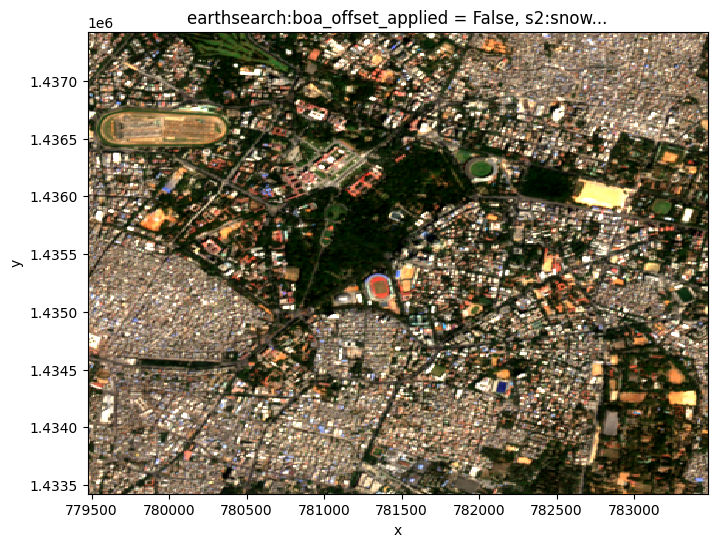

In [ ]:
# https://github.com/gjoseph92/stackstac/blob/v0.5.0/docs/basic.ipynb
# https://docs.xarray.dev/en/stable/generated/xarray.plot.imshow.html
# robust (bool, optional) – If True and vmin or vmax are absent, the colormap range is computed with 2nd and 98th percentiles instead of the extreme values.
# size (scalar, optional) – If provided, create a new figure for the plot with the given size: height (in inches) of each plot. See also: aspect.
median_composite.plot.imshow(robust=True, size=6);

# To fiddle around with the parameters
# median_composite.plot.imshow(rgb="band", size=6); # If you use this, this image is much darker!
# median_composite.plot.imshow(rgb="band", robust=True, size=8); # Changing the size parameter makes the picture bigger.


## Creating a true color median composite but with cloud masking using the SCL band

The following code is based on the code of the following YouTube video [here](https://www.youtube.com/watch?v=6eAWatQly9U).

In contrast to the previous image, we now select also the SCL band:

In [ ]:
rgb_aoi_scl = aoi.sel(band=["red", "green", "blue", "scl"])
rgb_aoi_scl

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (time: 6,
                                                                band: 4,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(6, 4, 400, 400), dtype=float64, chunksize=(1, 1, 400, 240), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2022-01-03...
    id                                       (time) <U24 'S2B_43PGQ_20220103_...
  * band                                     (band) <U12 'red' 'green' ... 'scl'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    ...                                       ...
    raster:bands                             (band) object None ... [{'nodata...
    gsd                                      (band) object 10 10 10 None
    common_name                              (band) object 'red' ... None
    center_wavelength                        (band) object 0.665 0.56 0.49 None
    full_width_half_max                      (band) object 0.038 0.045 ... None
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699960.0, 1390200.0, 809760.0...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 1500000.00|\n| 0.0...
    resolution:  10.0

In [ ]:
mask = rgb_aoi_scl.sel(band = 'scl')
mask

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (time: 6,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(6, 400, 400), dtype=float64, chunksize=(1, 400, 240), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2022-01-03...
    id                                       (time) <U24 'S2B_43PGQ_20220103_...
    band                                     <U12 'scl'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    ...                                       ...
    raster:bands                             object [{'nodata': 0, 'data_type...
    gsd                                      object None
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699960.0, 1390200.0, 809760.0...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 1500000.00|\n| 0.0...
    resolution:  10.0

In [ ]:
mask.data.shape

(6, 400, 400)

### Cloud masking for a single image

In order to understand masking, we first select one image (one time period) following the script [here](https://foundations.projectpythia.org/core/xarray/computation-masking.html). More specifically, let us select a cloudy image.

In [ ]:
cloudy_image = rgb_aoi_scl.sel(time = '2022-01-18', band=["red", "green", "blue", "scl"])
cloudy_image

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (time: 1,
                                                                band: 4,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(1, 4, 400, 400), dtype=float64, chunksize=(1, 1, 400, 240), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2022-01-18...
    id                                       (time) <U24 'S2A_43PGQ_20220118_...
  * band                                     (band) <U12 'red' 'green' ... 'scl'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    ...                                       ...
    raster:bands                             (band) object None ... [{'nodata...
    gsd                                      (band) object 10 10 10 None
    common_name                              (band) object 'red' ... None
    center_wavelength                        (band) object 0.665 0.56 0.49 None
    full_width_half_max                      (band) object 0.038 0.045 ... None
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699960.0, 1390200.0, 809760.0...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 1500000.00|\n| 0.0...
    resolution:  10.0

In [ ]:
cloudy_image

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (time: 1,
                                                                band: 4,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(1, 4, 400, 400), dtype=float64, chunksize=(1, 1, 400, 240), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2022-01-18...
    id                                       (time) <U24 'S2A_43PGQ_20220118_...
  * band                                     (band) <U12 'red' 'green' ... 'scl'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    ...                                       ...
    raster:bands                             (band) object None ... [{'nodata...
    gsd                                      (band) object 10 10 10 None
    common_name                              (band) object 'red' ... None
    center_wavelength                        (band) object 0.665 0.56 0.49 None
    full_width_half_max                      (band) object 0.038 0.045 ... None
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699960.0, 1390200.0, 809760.0...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 1500000.00|\n| 0.0...
    resolution:  10.0

In [ ]:
cloudy_image.shape

(1, 4, 400, 400)

In [ ]:
cloudy_image.dims

('time', 'band', 'y', 'x')

For the RGB plot to work (similar to the code above), we must get rid of the first dimension and obtain a (3, 400, 400) shape:

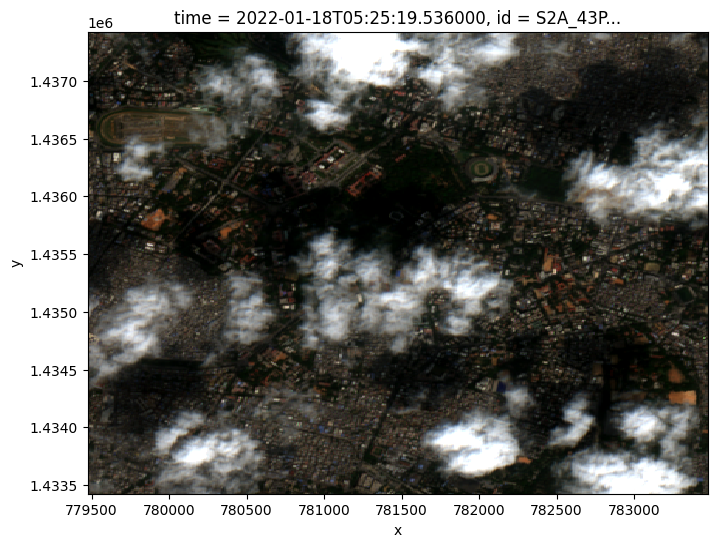

In [ ]:
cloudy_image.sel(band=["red", "green", "blue"]).squeeze().plot.imshow(robust=True, size=6); # If you do not use "squeeze", this produces an error as you need a 2D array.

Alternatively, we can specify the time variable (and avoid the "squeeze()" option.

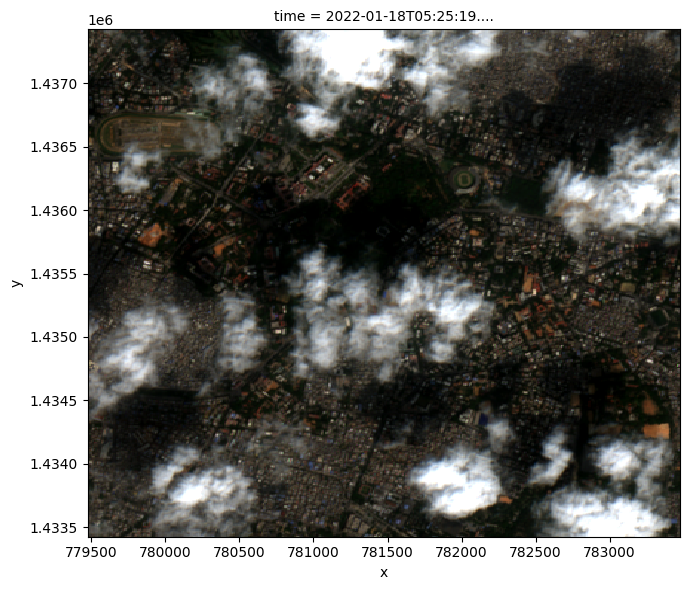

In [ ]:
cloudy_image.sel(band=["red", "green", "blue"]).plot.imshow(row="time", robust=True, size=6);

Let us see if we can access and visualise the cloud mask for this image.

In [ ]:
scl_mask_cloudy = rgb_aoi_scl.sel(time = '2022-01-18', band=["scl"])
scl_mask_cloudy

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (time: 1,
                                                                band: 1,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(1, 1, 400, 400), dtype=float64, chunksize=(1, 1, 400, 240), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2022-01-18...
    id                                       (time) <U24 'S2A_43PGQ_20220118_...
  * band                                     (band) <U12 'scl'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    ...                                       ...
    raster:bands                             (band) object [{'nodata': 0, 'da...
    gsd                                      (band) object None
    common_name                              (band) object None
    center_wavelength                        (band) object None
    full_width_half_max                      (band) object None
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699960.0, 1390200.0, 809760.0...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 1500000.00|\n| 0.0...
    resolution:  10.0

In [ ]:
scl_mask_cloudy.shape

(1, 1, 400, 400)

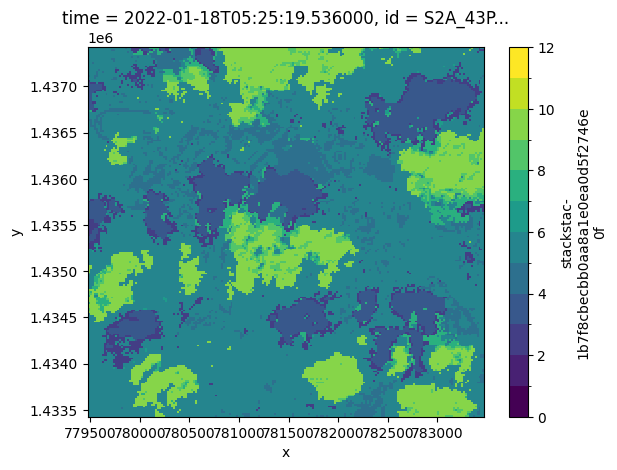

In [ ]:
# https://docs.xarray.dev/en/latest/user-guide/plotting.html
scl_mask_cloudy.plot(levels = [0, 1, 2, 3,4,5,6,7,8,9,10,11, 12])

Although we can discover some things from this, let us create a better plot with a legend. We first use squeeze -  TO DO

In [ ]:
scl_mask_cloudy_squeeze = scl_mask_cloudy.squeeze().to_numpy()

In [ ]:
print(scl_mask_cloudy_squeeze.shape)
print(type(scl_mask_cloudy_squeeze))

(400, 400)
<class 'numpy.ndarray'>


We can use any regular Python plotting functions and add a legend to it - CODE TO ADD.

A description of the SCL bands can be found [here](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/scene-classification/) among others.

More specifically:

| Code    | Description |
| -------- | ------- |
|0	| No Data (Missing data)|
|1	| Saturated or defective pixel|
|2	| Topographic casted shadows (called "Dark features/Shadows" for data before 2022-01-25)|
|3	| Cloud shadows	|
|4	| Vegetation		|
|5	| Not-vegetated	|
|6	| Water	|
|7	|Unclassified	|
|8	|Cloud medium probability	|
|9	|Cloud high probability	|
|10	|Thin cirrus |
|11	|Snow or ice|

Let us create a mask using the "where" function. Please see [here](https://foundations.projectpythia.org/core/xarray/computation-masking.html). We create a datacube that has the three bands and the SCL band.

In [ ]:
# cloudy_image_2 = rgb_aoi_scl.sel(time = '2022-01-18', band=["red", "green", "blue", "scl"])
# cloudy_image_2

In [ ]:
# Based on: https://youtu.be/6eAWatQly9U?t=1272
mask = cloudy_image.sel(band = 'scl')
keep_values = [2,4,5,6,7,11] # As per the table above, we keep the values for unsaturated and defective pixels,vegetation, non-vegetated, water, unclassified, snow or ice

We could select alternative values or drop values we do not want.

In [ ]:
binary_mask = mask.isin(keep_values)

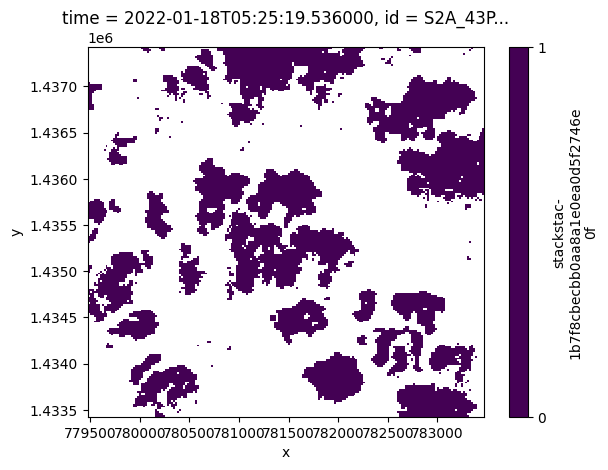

In [ ]:
binary_mask.squeeze().plot(levels = 2)

In [ ]:
# This is how the mask would look like (take the first 5 x 5 pixels from the left corner)
binary_mask.squeeze()[0:5,0:5].to_numpy()

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [ ]:
cloudy_image_masked = cloudy_image.where(binary_mask)
cloudy_image_masked.shape

(1, 4, 400, 400)

Plot the single image masked for the clouds:

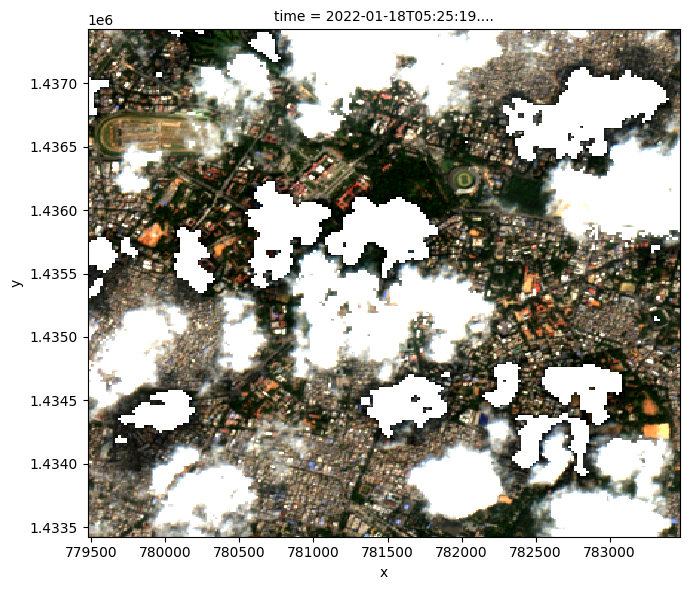

In [ ]:
cloudy_image_masked.sel(band=["red", "green", "blue"]).plot.imshow(row="time", robust=True, size=6);

Now, plot the old and the new image next to each other:

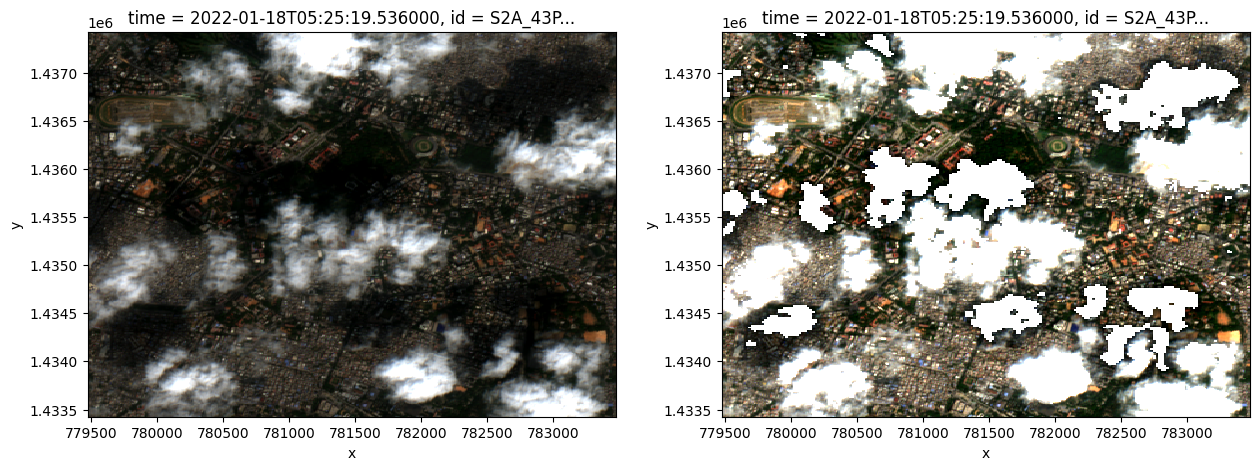

In [ ]:
import matplotlib.pyplot as plt
# https://foundations.projectpythia.org/core/xarray/computation-masking.html#masking-data
fig, axes = plt.subplots(ncols=2, figsize=(19, 6))
fig.set_size_inches(15,5)
cloudy_image.sel(band=["red", "green", "blue"]).squeeze().plot.imshow(ax=axes[0],robust=True)
cloudy_image_masked.sel(band=["red", "green", "blue"]).squeeze().plot.imshow(ax=axes[1],robust=True);
plt.show()

### Cloud free composite (using the SCL mask) for the entire datacube

We again take the data for the entire period:

In [ ]:
# rgb_aoi_scl

Create the cloud mask:

In [ ]:
mask_cube = rgb_aoi_scl.sel(band='scl')

And create the mask from this data cube:

In [ ]:
keep_values = [2,4,5,6,7,11] # As per the table above, we keep the values for unsaturated and defective pixels,vegetation, non-vegetated, water, unclassified, snow or ice# This is the same as above

Create the cloud mask for the data cube:

In [ ]:
binary_mask_cube = mask_cube.isin(keep_values)

In [ ]:
datacube_masked = rgb_aoi_scl.where(binary_mask_cube)
datacube_masked

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (time: 6,
                                                                band: 4,
                                                                y: 400, x: 400)>
dask.array<where, shape=(6, 4, 400, 400), dtype=float64, chunksize=(1, 1, 400, 240), chunktype=numpy.ndarray>
Coordinates: (12/47)
  * time                                     (time) datetime64[ns] 2022-01-03...
    id                                       (time) <U24 'S2B_43PGQ_20220103_...
  * band                                     (band) <U12 'red' 'green' ... 'scl'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    ...                                       ...
    s2:reflectance_conversion_factor         (time) float64 1.034 ... 1.022
    proj:epsg                                int64 32643
    s2:water_percentage                      (time) float64 1.717 ... 1.488
    mgrs:latitude_band                       <U1 'P'
    s2:datatake_id                           (time) <U34 'GS2B_20220103T05120...
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699960.0, 1390200.0, 809760.0...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 1500000.00|\n| 0.0...
    resolution:  10.0

To check, check the same time period out of this:

In [ ]:
cloudy_image_2 = datacube_masked.sel(time = '2022-01-18', band=["red", "green", "blue"])
cloudy_image_2

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (time: 1,
                                                                band: 3,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(1, 3, 400, 400), dtype=float64, chunksize=(1, 1, 400, 240), chunktype=numpy.ndarray>
Coordinates: (12/47)
  * time                                     (time) datetime64[ns] 2022-01-18...
    id                                       (time) <U24 'S2A_43PGQ_20220118_...
  * band                                     (band) <U12 'red' 'green' 'blue'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    ...                                       ...
    s2:reflectance_conversion_factor         (time) float64 1.034
    proj:epsg                                int64 32643
    s2:water_percentage                      (time) float64 1.494
    mgrs:latitude_band                       <U1 'P'
    s2:datatake_id                           (time) <U34 'GS2A_20220118T05114...
    epsg                                     int64 32643
Attributes:
    spec:        RasterSpec(epsg=32643, bounds=(699960.0, 1390200.0, 809760.0...
    crs:         epsg:32643
    transform:   | 10.00, 0.00, 699960.00|\n| 0.00,-10.00, 1500000.00|\n| 0.0...
    resolution:  10.0

In [ ]:
cloudy_image_2.shape

(1, 3, 400, 400)

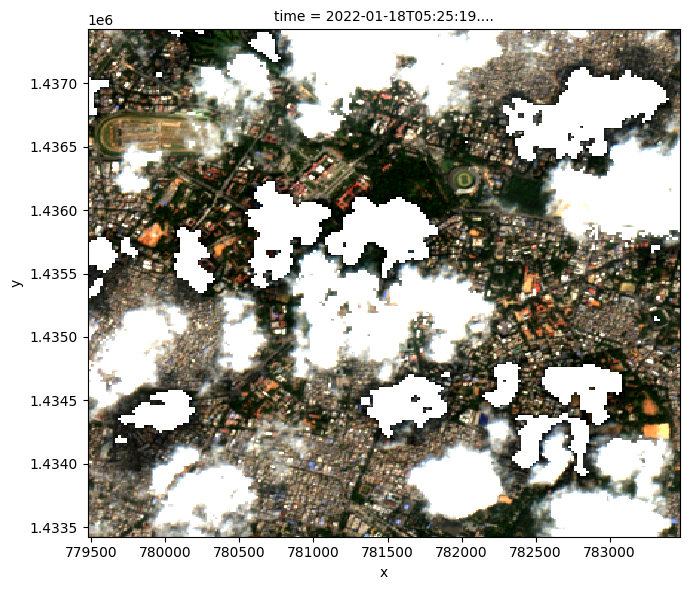

In [ ]:
cloudy_image_2.plot.imshow(row="time", robust=True, size=6);

We notice that we have obtained the exact same image!

In the last step, we need create the median composite:

In [ ]:
median_masked = datacube_masked.median(dim='time')
median_masked

<xarray.DataArray 'stackstac-1b7f8cbecbb0aa8a1e0ea0d5f2746e0f' (band: 4,
                                                                y: 400, x: 400)>
dask.array<nanmedian, shape=(4, 400, 400), dtype=float64, chunksize=(4, 400, 400), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * band                                     (band) <U12 'red' 'green' ... 'scl'
  * x                                        (x) float64 7.795e+05 ... 7.835e+05
  * y                                        (y) float64 1.437e+06 ... 1.433e+06
    earthsearch:boa_offset_applied           bool False
    s2:snow_ice_percentage                   int64 0
    s2:saturated_defective_pixel_percentage  int64 0
    ...                                       ...
    s2:sequence                              <U1 '0'
    grid:code                                <U10 'MGRS-43PGQ'
    processing:software                      object {'sentinel2-to-stac': '0....
    proj:epsg                                int64 32643
    mgrs:latitude_band                       <U1 'P'
    epsg                                     int64 32643

In [ ]:
median_composite_masked=median_masked.compute()

In a last step, we plot the cloud free composite:

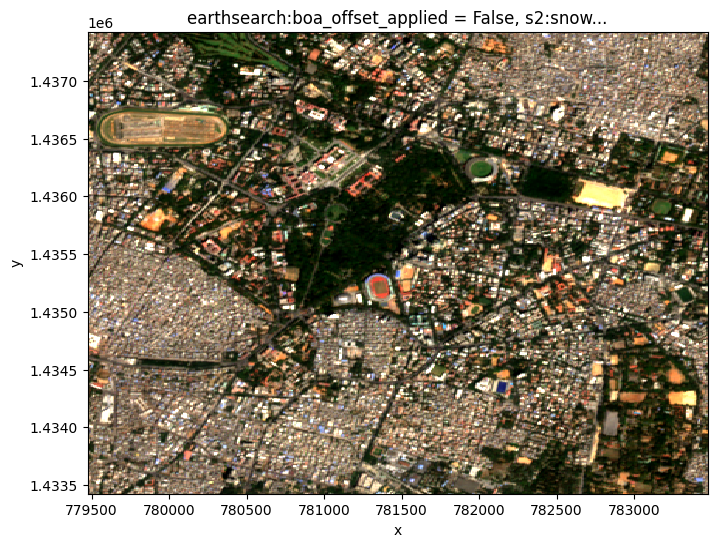

In [ ]:
median_composite_masked.sel(band=["red", "green", "blue"]).plot.imshow(robust=True, size=6);

## References

https://www.youtube.com/watch?v=6eAWatQly9U

https://stackstac.readthedocs.io/en/latest/basic.html

https://planetarycomputer.microsoft.com/docs/tutorials/cloudless-mosaic-sentinel2/

https://stacspec.org/en/tutorials/access-sentinel-2-data-aws/

https://stacspec.org/en/tutorials/reading-stac-planetary-computer/

https://www.element84.com/geospatial/introducing-earth-search-v1-new-datasets-now-available/

https://carpentries-incubator.github.io/geospatial-python/05-access-data.html

https://www.streambatch.io/knowledge/ndvi-from-sentinel-2-imagery-using-stac

https://github.com/dcherian/xarray-tutorial/blob/master/online-tutorial-series/01_xarray_fundamentals.ipynb

https://github.com/spatialthoughts/python-tutorials/blob/main/pc_sentinel2_composite.ipynb

https://foundations.projectpythia.org/core/xarray/computation-masking.html#masking-data
